# **Data preparation**

In [1]:
DATA_SOURCE = "../../01_data/adult_reconstruction.csv"
FILE_TO_SAVE = "../../01_data/prepared_data.csv"

In [2]:
import pandas as pd
import numpy as np

import preprocessing_utils

2022-11-25 15:15:57.775648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 15:15:58.019921: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 15:15:58.076963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 15:15:58.076986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
census_data = pd.read_csv(DATA_SOURCE)

## Overview

In [4]:
census_data.head()

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial


<AxesSubplot:>

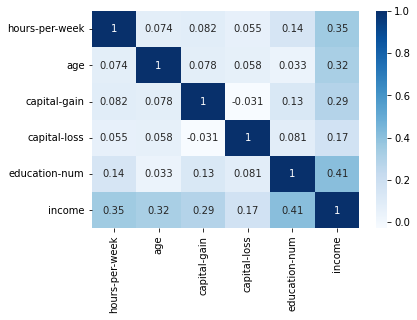

In [5]:
import seaborn as sb
corr = census_data.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

<AxesSubplot:>

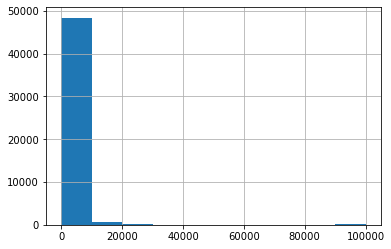

In [6]:
census_data["capital-gain"].hist()

## Dropping (label) outliers

We will drop those records, which are considered to be outliers (i.e. income>95%)

In [7]:
census_data["income"] = (census_data["income"]).astype(int)

In [8]:
census_data = census_data[census_data["workclass"] != "?"]

Text(0.5, 1.0, 'Histogram of incomes\n(with outliers)')

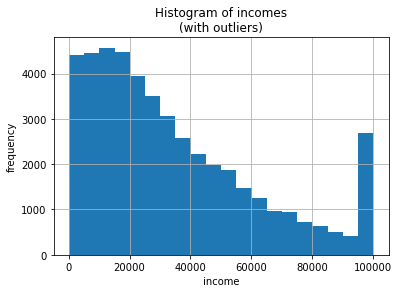

In [9]:
import matplotlib.pyplot as plt
census_data["income"].hist(bins=20)
plt.xlabel("income")
plt.ylabel("frequency")
plt.title("Histogram of incomes\n(with outliers)")

In [10]:
census_data = census_data[census_data["income"] <= census_data["income"].quantile(.95)]

In [11]:
income_categories = []
for i,r in census_data.iterrows():
    cat = 0
    if r["income"] >= 50000:
        cat = 2
    elif r["income"] >= 20000:
        cat = 1
    else:
        cat = 0
    income_categories.append(cat)
census_data["income-category"] = income_categories

In [12]:
census_data.to_csv("../../01_data/census_labeled_indexed.csv", index_label="index")

Text(0.5, 1.0, 'Histogram of incomes\n(withot outliers)')

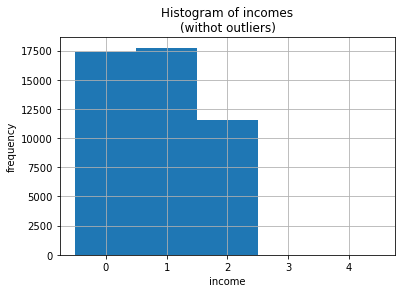

In [13]:
import matplotlib.pyplot as plt
census_data["income-category"].hist(bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5,])
plt.xlabel("income")
plt.ylabel("frequency")
plt.title("Histogram of incomes\n(withot outliers)")

## Partitioning data

In [15]:
categorical = ["workclass",
               "marital-status",
               "relationship",
               "race",
               "native-country",
               "occupation"]
numeric_mean_std = ["hours-per-week", "age",]
numeric_max = ["capital-gain", "capital-loss", "education-num"]

In [18]:
from importlib import reload
reload(preprocessing_utils)

indices = []
indices.append(census_data["education-num"] < 10) #under educated
indices.append(census_data["education-num"] >= 13) #well educated
indices.append(np.logical_and(census_data["education-num"]>=10, census_data["education-num"]<13)) #college educated

prepared_X, code_dict = preprocessing_utils.categorical_encoding_and_scaling(census_data, categorical, numeric_mean_std, numeric_max)
prepared_X = np.hstack([prepared_X, np.array(census_data["gender"]=="Male").astype(int).reshape([len(prepared_X), 1])])
#prepared_y = np.array(census_data["income"]/max(census_data["income"])).reshape([len(prepared_X), 1])
prepared_y, _ = preprocessing_utils.categorical_encoding_and_scaling(census_data, ["income-category"], [], [])

(46672,)
(46672, 2)
(46672,)
(46672, 3)
(46672,)
(46672, 4)


In [20]:
import json

code_dict["gender"] = {"Female": 0, "Male": 1}

with open("../../01_data/code_dict.json", "w") as code_file:
    json.dump(code_dict, code_file)

## Train/Test splitting

In [19]:
TEST_PORTION = .1
TRAIN_PATH = "../../01_data/train/"
TEST_PATH = "../../01_data/test/"

In [20]:
names = ["under_educated", "well_educated", "college_educated"]

In [21]:
prepared_y.shape

(46672, 3)

In [22]:
for i,name in enumerate(names):
    limit = int(TEST_PORTION*np.sum(indices[i]))
    np.savetxt(TEST_PATH+name+"_features.csv", prepared_X[indices[i]][:limit], delimiter=",")
    np.savetxt(TRAIN_PATH+name+"_features.csv", prepared_X[indices[i]][limit:], delimiter=",")
    np.savetxt(TEST_PATH+name+"_labels.csv", prepared_y[indices[i]][:limit], delimiter=",")
    np.savetxt(TRAIN_PATH+name+"_labels.csv", prepared_y[indices[i]][limit:], delimiter=",")